<a href="https://colab.research.google.com/github/willian2610/Diagnostico-por-Imagens/blob/master/CNN_Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Final - Diagnóstico por Imagem
Implementação da Rede Neural Convolucional para detecção de tumor cerebral.

<B>ALUNO:</B> WILLIAN DE VARGAS

# Requisitos

In [ ]:
%%capture
!pip install opencv-python

In [ ]:
%%capture
!pip install scikit-image

In [ ]:
%%capture
!pip install matplotlib

In [ ]:
%%capture
!pip install --upgrade scikit-learn

In [ ]:
%%capture
!pip install keras

In [ ]:
%%capture
!pip install tensorflow --user

In [ ]:
%%capture
!pip install mlxtend

In [ ]:
%%capture
!pip install progressbar

# Importações

In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
#from IPython.display import clear_output
from skimage.transform import resize
import matplotlib.pyplot as plt
from random import randrange

# Carregamento e pré-processamento do dataset

In [ ]:
# Imports necessários para apresentar uma barra de progresso durante o carregamento das imagens
from progressbar import AnimatedMarker, Bar, ETA, FileTransferSpeed, Percentage, ProgressBar

# Separando as imagens nas diferentes classes (tumor_yes/tumor_no)

SOURCE_PATH = 'input/'

images_list = []
label = []

for CLASS in os.listdir(SOURCE_PATH):
    widget = [f"Loading class '{CLASS}': \t", Percentage(), Bar(marker=AnimatedMarker()), " \t", ETA(), " \t", FileTransferSpeed()]
    pbar = ProgressBar(widgets=widget)
    
    if (not CLASS.startswith('pred') and (not CLASS.startswith('.'))):
        
        for (i, FILE_NAME) in enumerate(pbar((os.listdir(f"{SOURCE_PATH}{CLASS}")))):
            image_path = f"{SOURCE_PATH}{CLASS}/{FILE_NAME}"
            image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)  
            # Realizando o redimensionamento das imegens (etapa pertencente ao pré-processamento do dataset)
            image = resize(image, (256,256,3), mode='constant', preserve_range=True)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            # Binarizando as classes: 0 para 'no' e 1 para 'yes'
            img_label = 1 if (CLASS=='yes') else 0
            images_list.append(image)
            label.append(img_label)  

Loading class 'no': 	100%|||||||||||||||||||||||||| 	Time: 0:00:26 	 56.20  B/s
Loading class 'yes': 	100%||||||||||||||||||||||||| 	Time: 0:00:32 	 45.96  B/s


In [ ]:
print(f"Número total de imagens: {len(images_list)}")
print(f"Número de rótulos 'no' (0): {label.count(0)}")
print(f"Número de rótulos 'yes' (1): {label.count(1)}")

Número total de imagens: 3000
Número de rótulos 'no' (0): 1500
Número de rótulos 'yes' (1): 1500


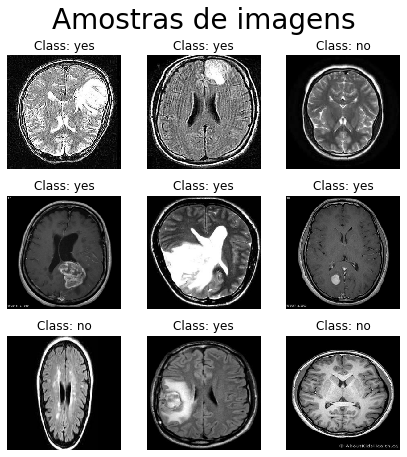

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(6,6))

fig.suptitle("Amostras de imagens", y=1.05, fontsize=28)

for i in range(9):
    rand_index = randrange(len(images_list))
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    img_class = 'yes' if (label[rand_index])==1 else 'no'
    plt.title(f'Class: {img_class}')
    plt.imshow(images_list[rand_index], cmap='gray', vmin=0, vmax=255)
    
plt.tight_layout()
plt.show()

# Separação do Dataset em conjuntos de treino e teste (Data Split)

In [ ]:
from sklearn.model_selection import train_test_split

# Definindo que 20% das imagens serão destinadas para o conjunto de testes. 
# Os outros 80% serão destinadas ao conjunto de treino.
images_train, images_test, labels_train, labels_test = train_test_split(images_list, label, test_size=0.2, random_state=42)

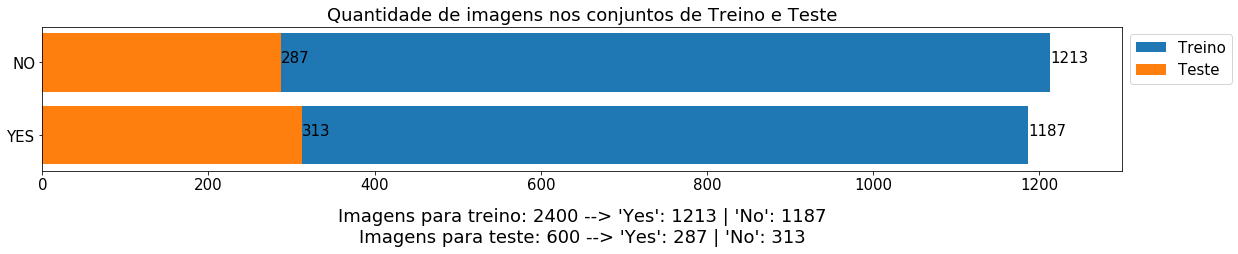

In [ ]:
# Convertendo as listas de imagens e labels para numpy.ndarrays
images_train = np.array(images_train)
images_test = np.array(images_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'text.color': 'black'})

labels_plot = ["YES", "NO"]
labels_train_count = [(labels_train==0).sum(), (labels_train==1).sum()]
labels_test_count = [(labels_test==0).sum(), (labels_test==1).sum()]

fig = plt.figure(figsize=(15,2))
ax = fig.add_axes([0,0,1,1])
ax.barh(labels_plot, labels_train_count)
ax.barh(labels_plot, labels_test_count)
ax.legend(labels=["Treino", "Teste"], fontsize=15, bbox_to_anchor=(1,1))
ax.set_xlim(xmax=1300)

for index, value in enumerate(labels_train_count):
    plt.text(value, index, str(value), fontsize=15)
for index, value in enumerate(labels_test_count):
    plt.text(value, index, str(value), fontsize=15)

plt.title("Quantidade de imagens nos conjuntos de Treino e Teste")

footnote = (f"Imagens para treino: {len(images_train)} --> 'Yes': {(labels_train==1).sum()} | 'No': {(labels_train==0).sum()}\n"+
             f"Imagens para teste: {len(images_test)} --> 'Yes': {(labels_test==1).sum()} | 'No': {(labels_test==0).sum()}")
plt.figtext(0.5, -0.5, footnote, ha="center", fontsize=18)

plt.show()

# Construção do modelo

In [ ]:
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Modelo

In [ ]:
model_1 = Sequential()

model_1.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Conv2D(filters=32, kernel_size=(3,3), padding='valid', activation='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Conv2D(filters=128, kernel_size=(3,3), padding='valid', activation='relu'))
model_1.add(MaxPool2D(pool_size=(2,2)))

model_1.add(Flatten())

model_1.add(Dropout(0.7))
model_1.add(Dense(128, activation='relu'))

model_1.add(Dropout(0.7))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

# Treinamento da rede

In [ ]:
results_1 = model_1.fit(images_train, labels_train, epochs=30, validation_data=(images_test, labels_test))

Epoch 1/30
75/75 [==============================] - 67s 875ms/step - loss: 0.5807 - accuracy: 0.6892 - val_loss: 0.4897 - val_accuracy: 0.7500
Epoch 2/30
75/75 [==============================] - 62s 833ms/step - loss: 0.5116 - accuracy: 0.7479 - val_loss: 0.4705 - val_accuracy: 0.7883
Epoch 3/30
75/75 [==============================] - 62s 828ms/step - loss: 0.4637 - accuracy: 0.7779 - val_loss: 0.3972 - val_accuracy: 0.8417
Epoch 4/30
75/75 [==============================] - 61s 821ms/step - loss: 0.4200 - accuracy: 0.8075 - val_loss: 0.3683 - val_accuracy: 0.8367
Epoch 5/30
75/75 [==============================] - 62s 823ms/step - loss: 0.3775 - accuracy: 0.8321 - val_loss: 0.2999 - val_accuracy: 0.8800
Epoch 6/30
75/75 [==============================] - 62s 826ms/step - loss: 0.3444 - accuracy: 0.8554 - val_loss: 0.2829 - val_accuracy: 0.8900
Epoch 7/30
75/75 [==============================] - 61s 820ms/step - loss: 0.3088 - accuracy: 0.8650 - val_loss: 0.2594 - val_accuracy: 0.9033

# Resultados de acurácia e perda

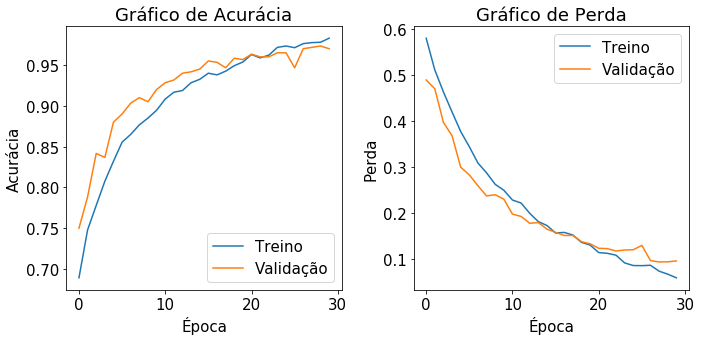

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Gráfico de Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.plot(results_1.history['accuracy'])
plt.plot(results_1.history['val_accuracy'])
plt.legend(['Treino', 'Validação'], loc='lower right')

plt.subplot(122)
plt.title('Gráfico de Perda')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.plot(results_1.history['loss'])
plt.plot(results_1.history['val_loss'])
plt.legend(['Treino', 'Validação'], loc='upper right')

plt.tight_layout()
plt.show()

# Teste da rede

In [ ]:
label_pred_1 = model_1.predict(images_test)
result_pred_1 = np.round(label_pred_1) 

# Resultados do teste

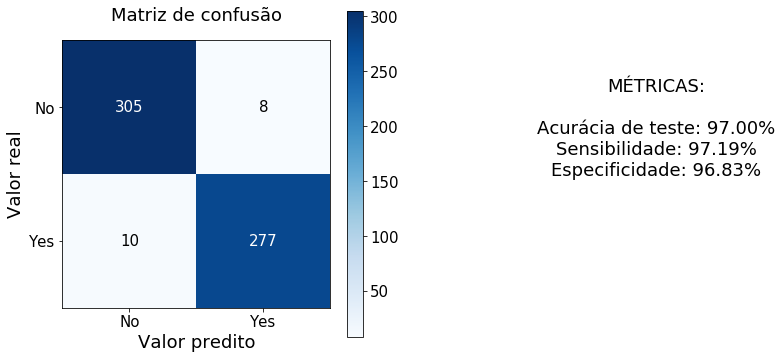

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

cmat = confusion_matrix(labels_test, result_pred_1, labels=[0,1]) 
cmat_df = pd.DataFrame(cmat)

# Quantidade de casos que foram corretamente identificados.
acuracia = np.sum(np.diag(cmat))*100/np.sum(cmat)
# Proporção de casos POSITIVOS que foram identificados corretamente.
sensibilidade = cmat_df.iloc[1][1]/(cmat_df.iloc[0][1]+cmat_df.iloc[1][1])*100
# Proporção de casos NEGATIVOS que foram identificados corretamente.
especificidade = cmat_df.iloc[0][0]/(cmat_df.iloc[1][0]+cmat_df.iloc[0][0])*100

fig, ax = plot_confusion_matrix(conf_mat = cmat, 
                                figsize = (6, 6), 
                                cmap = plt.cm.Blues, 
                                colorbar = True)
ax.set_xticklabels(['', 'No', 'Yes'])
ax.set_yticklabels(['', 'No', 'Yes'])
plt.xlabel('Valor predito', fontsize=18)
plt.ylabel('Valor real', fontsize=18)
plt.title('Matriz de confusão', fontsize=18)

text = ("MÉTRICAS:\n\n"+
        f"Acurácia: {'{:.2f}'.format(acuracia)}%\n"+
        f"Sensibilidade: {'{:.2f}'.format(sensibilidade)}%\n"+
        f"Especificidade: {'{:.2f}'.format(especificidade)}%")

plt.figtext(1.5, 0.5, text, ha="center", fontsize=18)
plt.show()

## Visualização da arquitetura

In [ ]:
%%capture
!pip install visualkeras --user

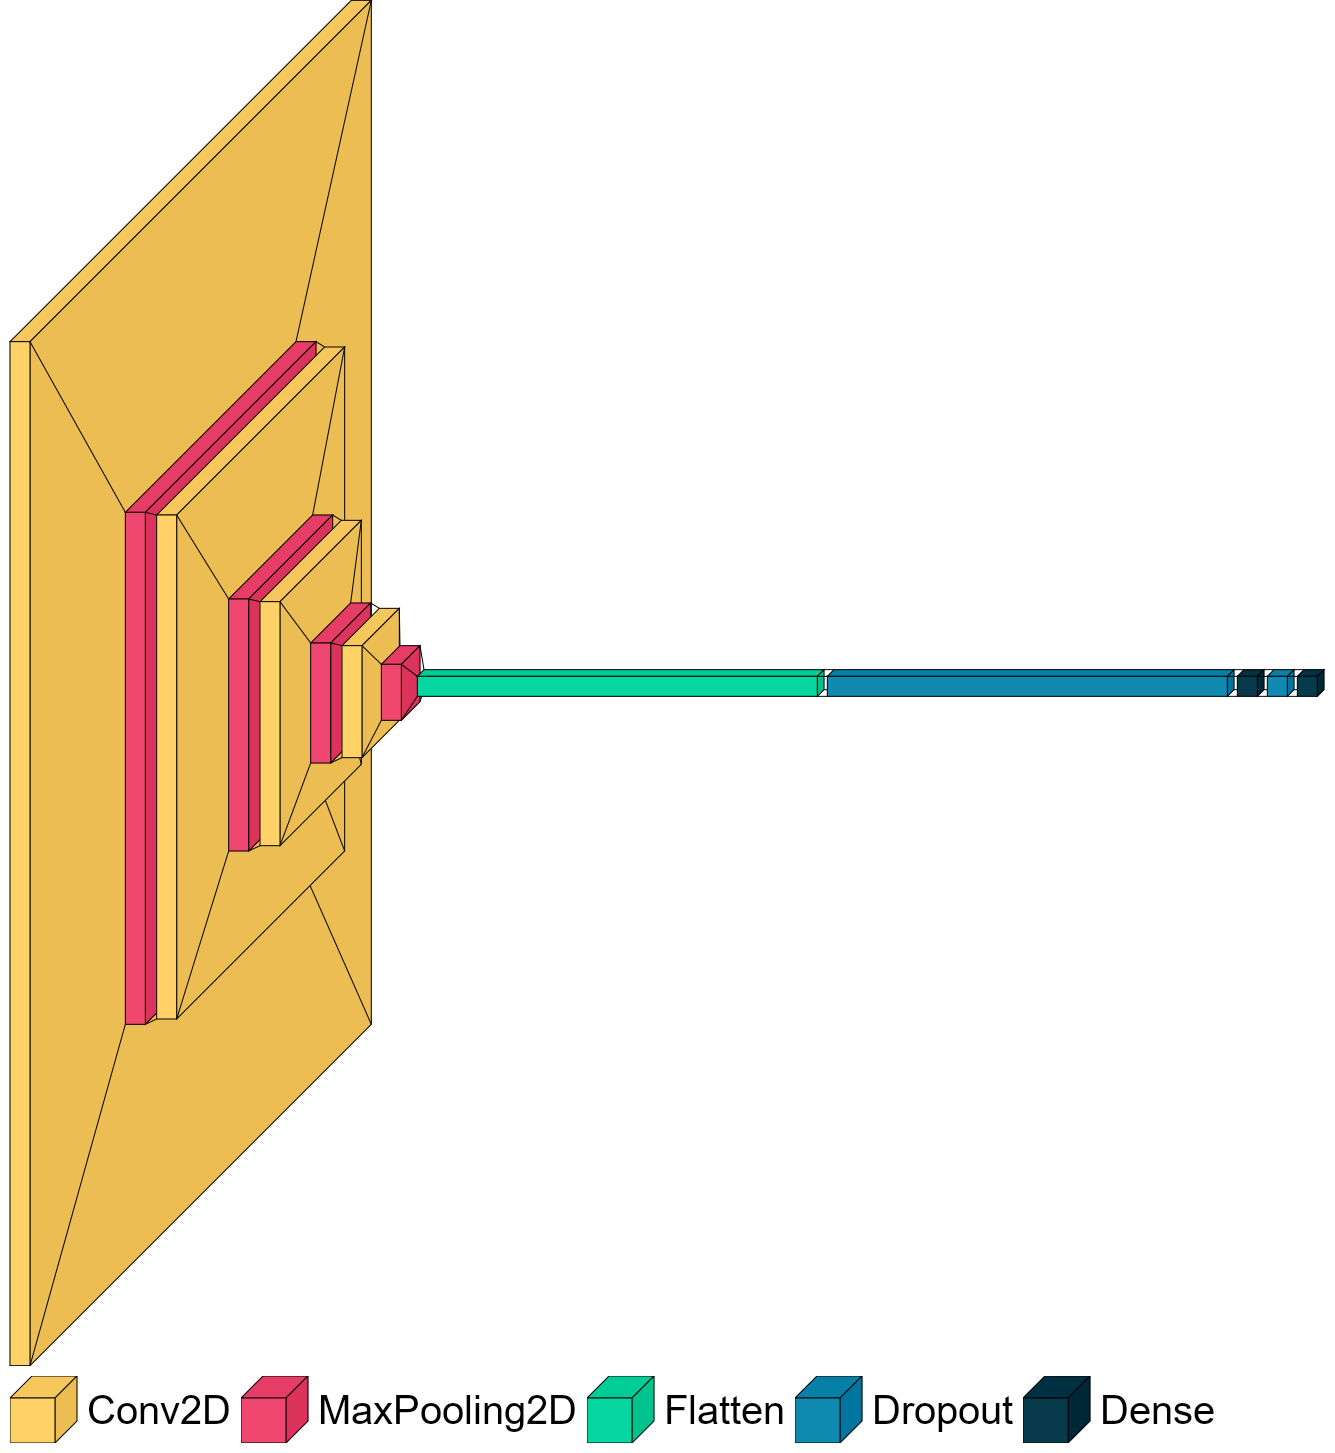

In [ ]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 40)

visualkeras.layered_view(model_1, legend=True, font=font, spacing=20).show() # display using your system viewer
#visualkeras.layered_view(model_1, to_file='my_cnn.png', legend=True, font=font) # write to disk
#visualkeras.layered_view(model_1, to_file='output.png', legend=True, font=font).show() # write and show